# Putting it all togather

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn.cross_validation import KFold

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, scale, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier

pd.options.mode.chained_assignment = None


/Users/boris/.pyenv/versions/anaconda2-5.0.0/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def import_data():
    # For .read_csv, always use header=0 when you know row 0 is the header row
    df = pd.read_csv("./data/ElectionsData-full.csv", header=0)

    df['split'] = 0
    indices = KFold(n=len(df), n_folds=5, shuffle=True)._iter_test_indices()
    df['split'][indices.next()] = 1
    df['split'][indices.next()] = 2
    raw_data = df.copy()

    raw_data[raw_data['split'] == 0].drop('split', axis=1).to_csv('./data/output/raw_train.csv', index=False, sep=',')
    raw_data[raw_data['split'] == 1].drop('split', axis=1).to_csv('./data/output/raw_test.csv', index=False, sep=',')
    raw_data[raw_data['split'] == 2].drop('split', axis=1).to_csv('./data/output/raw_validation.csv', index=False)

    return df

df_old = import_data()
df_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
Vote                                             10000 non-null object
Occupation_Satisfaction                          9809 non-null float64
Avg_monthly_expense_when_under_age_21            9809 non-null float64
AVG_lottary_expanses                             9818 non-null float64
Most_Important_Issue                             9909 non-null object
Avg_Satisfaction_with_previous_vote              9829 non-null float64
Looking_at_poles_results                         9909 non-null object
Garden_sqr_meter_per_person_in_residancy_area    9794 non-null float64
Married                                          9929 non-null object
Gender                                           9928 non-null object
Voting_Time                                      9903 non-null object
Financial_balance_score_(0-1)                    9810 non-null float64
%Of_Household_Income                         

# Loading the new data

In [3]:
train_split = 0
test_split = 1
validation_split = 2
new_split = 3

In [4]:
df_new = pd.read_csv('./data/ElectionsData_Pred_Features.csv', header=0)
df_new['split'] = new_split

### Looking at the data
checking for nil values

In [5]:
df_new.describe()

,IdentityCard_Num,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Financial_balance_score_.0.1.,X.Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,...,Weighted_education_rank,X._satisfaction_financial_policy,Avg_monthly_income_all_years,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years,split
count,10000.00000,9944.000000,9935.000000,9951.000000,9930.000000,9941.000000,9938.000000,9942.000000,9936.000000,9934.000000,...,9936.000000,9932.000000,9936.000000,9925.000000,9934.000000,9943.000000,9929.000000,9937.000000,9925.000000,10000.0
mean,5000.50000,5.531376,505.998923,68755.239663,168.550741,412.560822,0.498689,0.499769,4.980705,5.016348,...,205.153477,49.966199,49580.231521,72.837280,2.001007,671.019263,9.660288,474.314407,0.664282,3.0
std,2886.89568,2.864049,432.341238,70172.943560,144.040190,135.629175,0.289392,0.287132,2.886140,2.883037,...,109.418043,29.008778,85147.494780,20.308241,1.253927,126.447079,2.757766,108.879774,1.047991,0.0
min,1.00000,1.000000,-760.581980,-153663.209748,-253.527327,0.935073,0.000297,0.000056,0.000214,0.000159,...,5.855398,0.004262,9.751126,30.000000,0.000000,49.850510,5.000000,0.174146,0.000000,3.0
25%,2500.75000,3.000000,198.987026,25323.714338,66.288574,316.627960,0.247393,0.250963,2.445209,2.549850,...,126.969613,24.852723,4622.859358,60.000000,1.000000,596.080915,8.000000,413.332738,0.000000,3.0
50%,5000.50000,6.000000,385.874725,49128.853934,128.606860,397.211181,0.497605,0.500869,5.015930,5.052688,...,202.050611,49.587589,16832.901706,70.000000,2.000000,663.039829,9.000000,472.642204,0.000000,3.0
75%,7500.25000,8.000000,694.844597,87737.778185,231.159661,485.704871,0.748513,0.746006,7.483365,7.495372,...,257.734904,75.381370,54058.397064,90.000000,3.000000,731.554884,12.000000,530.001654,1.000000,3.0
max,10000.00000,10.000000,2297.295696,568994.981131,765.765232,826.628682,0.999697,0.999984,9.997253,9.999821,...,805.916767,99.996539,587172.155862,100.000000,7.000000,1069.941023,16.000000,772.526144,10.000000,3.0


In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
IdentityCard_Num                                 10000 non-null int64
Occupation_Satisfaction                          9944 non-null float64
Avg_monthly_expense_when_under_age_21            9935 non-null float64
AVG_lottary_expanses                             9951 non-null float64
Most_Important_Issue                             9964 non-null object
Avg_Satisfaction_with_previous_vote              9930 non-null float64
Looking_at_poles_results                         9972 non-null object
Garden_sqr_meter_per_person_in_residancy_area    9941 non-null float64
Married                                          9970 non-null object
Gender                                           9974 non-null object
Voting_Time                                      9973 non-null object
Financial_balance_score_.0.1.                    9938 non-null float64
X.Of_Household_Income                         

__During this exersice we will try to treat the new data and the validation data the same
Meaning we will do the same operations on both, and than measure our success with the validation data.__

In [7]:
a = set(df_new.columns)
b = set(df_old.columns)

print "Only in df_new"
print "_" * 40
for f in sorted(a-b):
    print f

print "Only in df_validation"
print "_" * 40
for f in sorted(b-a):
    print f

Only in df_new
________________________________________
Financial_balance_score_.0.1.
IdentityCard_Num
X.Of_Household_Income
X.Time_invested_in_work
X._satisfaction_financial_policy
Only in df_validation
________________________________________
%Of_Household_Income
%Time_invested_in_work
%_satisfaction_financial_policy
Financial_balance_score_(0-1)
Vote


#### Looks like we have broken columns between validation and new data. lets fix that:

In [8]:
df_new["%Of_Household_Income"] = df_new["X.Of_Household_Income"]
df_new["%Time_invested_in_work"] = df_new["X.Time_invested_in_work"]
df_new["%_satisfaction_financial_policy"] = df_new["X._satisfaction_financial_policy"]
df_new["Financial_balance_score_(0-1)"] = df_new["Financial_balance_score_.0.1."]

df_new.drop(['X.Of_Household_Income', 'X.Time_invested_in_work', 'X._satisfaction_financial_policy', 'Financial_balance_score_.0.1.'],inplace=True, axis=1)

## Preprocessing the new data and the Validation set

first, we want to "hide" unwanted colums from each dataset: 
- df_validation - has the "Vote" column 
- df_new - has the "IdentityCard_Num" column.

we will remove those for the data cleansing process, and glue them back after we're done.
We decided to group all the data together for the data cleansing and filling data, that we will split it apart again.

In [9]:
df_all = df_new.append(df_old, ignore_index=True)

df_Votes = df_all['Vote']
df_Ids = df_all['IdentityCard_Num']
df_split = df_all['split']

df_all = df_all.drop(['IdentityCard_Num', 'Vote','split'], axis=1)


#### Grouping out features

In [10]:
def group_features(_df):
    _df = _df.dropna()
    all_features = _df.columns
    
    exclude = {'Vote', 'IdentityCard_Num', 'split'}
    categorical_features = list(set(_df.select_dtypes(include=["object"]).columns) - exclude)
    numeric_features = list(set(_df.select_dtypes(exclude=["object"]).columns) - exclude)

    return [all_features, categorical_features, numeric_features]

all_features, categorical_features, numeric_features = group_features(df_all)


#### Categorial Features

In [11]:
for f in categorical_features:
    print f

Gender
Married
Will_vote_only_large_party
Voting_Time
Looking_at_poles_results
Financial_agenda_matters
Most_Important_Issue
Main_transportation
Age_group
Occupation


#### Numeric Features


In [12]:
for f in numeric_features:
    print f

%Time_invested_in_work
Avg_Residancy_Altitude
Overall_happiness_score
Number_of_valued_Kneset_members
Avg_monthly_expense_when_under_age_21
Avg_size_per_room
Financial_balance_score_(0-1)
%Of_Household_Income
AVG_lottary_expanses
Avg_monthly_household_cost
Occupation_Satisfaction
Yearly_IncomeK
%_satisfaction_financial_policy
Avg_monthly_income_all_years
Avg_education_importance
Garden_sqr_meter_per_person_in_residancy_area
Number_of_differnt_parties_voted_for
Phone_minutes_10_years
Political_interest_Total_Score
Yearly_ExpensesK
Avg_environmental_importance
Last_school_grades
Num_of_kids_born_last_10_years
Avg_Satisfaction_with_previous_vote
Weighted_education_rank
Avg_government_satisfaction
Avg_monthly_expense_on_pets_or_plants


In [13]:
def rows_with_nan(_df):
    return Counter(_df.isnull().sum(axis=1).tolist())

def plot_rows_with_nan(_df, name=""):
    counter = rows_with_nan(_df)
    labels, histogram = zip(*counter.most_common())
    fig1, ax1 = plt.subplots()
    ax1.pie(histogram, labels=labels,
            colors = ['green', 'yellowgreen', 'yellow','orange', 'red'],
            autopct = lambda(p): '{:.0f}  ({:.2f}%)'.format(p * sum(histogram) / 100, p))
    ax1.axis('equal')
    plt.title(name)
    plt.show()
    

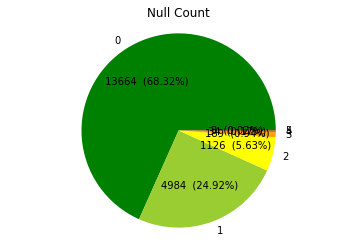

In [14]:
plot_rows_with_nan(df_all, "Null Count")

We can see that the new data has a lot if missing data.
Lets try to fill it.

# Filling the Data
In ex2 we showed that Most_Important_Issue is a mupltiplication of Last_school_grades.
lets fill with this info the missing values

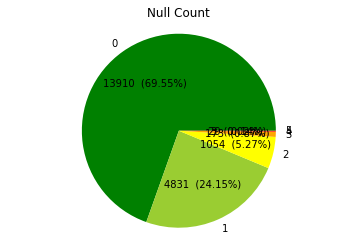

In [15]:
def fill_most_important_issue_and_grades_boris(df):
    translate_map = {
        'Military': 30.0,
        'Healthcare': 80.0,
        'Environment': 90.0,
        'Financial': 60.0,
        'Education': 100.0,
        'Foreign_Affairs': 40.0,
        'Social': 70.0,
        'Other': 50.0
    }

    inv_map = {v: k for k, v in translate_map.iteritems()}

    for index, row in df.iterrows():
        if pd.isnull(row['Last_school_grades']) and pd.isnull(row['Most_Important_Issue']):
            continue
        if pd.isnull(row['Last_school_grades']):
            df.loc[index, ['Last_school_grades']] = translate_map[row['Most_Important_Issue']]
        if pd.isnull(row['Most_Important_Issue']):
            df.loc[index, ['Most_Important_Issue']] = inv_map[row['Last_school_grades']]
    
    return df
    
df_all = fill_most_important_issue_and_grades_boris(df_all)

plot_rows_with_nan(df_all, "Null Count")



### Using Pearson's Correlation Coefficient

At this stage we are looking for corrlation between features
We've set a threshold of 0.7 for the pearson's correlation coefficient. 
Any two features with a value of that and above will be considered "highly correlated" and will be used to to fill the data by multiplying the value from one column by that ratio and set it to the other.

Since most of the columns are either complete or have at most 1 missing value, this will be a very useful tool.

Our method will start from the most corrlated features till it gets to 0.7.

In [16]:

def fill_numeric_by_correlation(_df, factor, features):
    cor = _df[features].dropna().corr()
    print "We choose " + str(factor) + " correlation as correlated"
    indices = np.where(cor > factor)
    indices = [(cor.index[x], cor.columns[y], cor.loc[cor.index[x],cor.columns[y]]) for x, y in zip(*indices) if  x < y]
    indices = sorted(indices, key=lambda pair: pair[2], reverse=True)
    for pair in indices:
        fill_f1_with_f2(_df, pair[0], pair[1], pair[2])


def fill_f1_with_f2(_df, f1, f2, val):
    ratio = _df[f1].mean() / _df[f2].mean()
    print 'Filling ' + f1 + ' with ' + f2 + ' due to correlation of %f'% val
    for index, row in _df[_df[f1 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f2][index]):
            _df[f1 + "_fill"][index] = _df[f2][index] * ratio
    
    ratio = _df[f2].mean() / _df[f1].mean()
    print 'Filling ' + f2 + ' with ' + f1 + ' due to correlation %f'% val
    for index, row in _df[_df[f2 + "_fill"].isnull()].iterrows():
        if ~np.isnan(_df[f1][index]):
            _df[f2 + "_fill"][index] = _df[f1][index] * ratio

def remove_fill(_df, features):
    for f in features:
        _df[f] = _df[f + "_fill"]
        del _df[f + "_fill"]

def create_fill(_df, features):
    for f in features:
        _df[f + "_fill"] = _df[f]

********************************************************************************
We choose 0.7 correlation as correlated
Filling Avg_monthly_expense_when_under_age_21 with Avg_Satisfaction_with_previous_vote due to correlation of 1.000000
Filling Avg_Satisfaction_with_previous_vote with Avg_monthly_expense_when_under_age_21 due to correlation 1.000000
Filling Garden_sqr_meter_per_person_in_residancy_area with Avg_monthly_expense_on_pets_or_plants due to correlation of 0.990138
Filling Avg_monthly_expense_on_pets_or_plants with Garden_sqr_meter_per_person_in_residancy_area due to correlation 0.990138
Filling Avg_size_per_room with Yearly_IncomeK due to correlation of 0.977773
Filling Yearly_IncomeK with Avg_size_per_room due to correlation 0.977773
Filling Garden_sqr_meter_per_person_in_residancy_area with Phone_minutes_10_years due to correlation of 0.975236
Filling Phone_minutes_10_years with Garden_sqr_meter_per_person_in_residancy_area due to correlation 0.975236
Filling Phone_minut

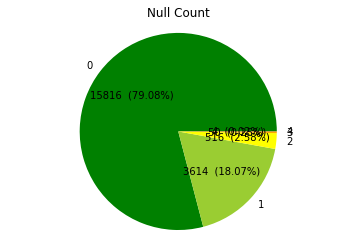

In [17]:
corr_factor = 0.7
print "**" * 40
create_fill(df_all, numeric_features)
fill_numeric_by_correlation(df_all, corr_factor, numeric_features)
remove_fill(df_all, numeric_features)
plot_rows_with_nan(df_all, "Null Count")


### Lets check the missing values status now
looks like we made an improvment, but there is still a way to go.

In [18]:
# Helper From Ex02

def train_on_feature(df, feature):
    train_data_X = df.drop([feature], axis=1).values
    train_data_Y = df[feature].values
    clf = RandomForestRegressor(n_estimators=50)
      
    return clf.fit(train_data_X, train_data_Y)

def build_clf(df, feature):
    df_tmp = df.copy()
    df_tmp_noNaN = df_tmp.dropna()
    print feature
    print len(df_tmp[pd.isnull(df_tmp[feature])])
    to_predict = df_tmp[pd.isnull(df_tmp[feature])].drop([feature],axis=1)
    clf = train_on_feature(df_tmp_noNaN, feature)
    return to_predict, clf


def fill_numerical(_df, numeric_features):
    results = {}
    df_numeric= _df[numeric_features]
    
    indeces_with_less_than_2_nan = [df_numeric.loc[k].isnull().sum() < 2 for k in df_numeric.index.values]
    df_for_prediction = df_numeric.loc[indeces_with_less_than_2_nan]
    
    for feature in numeric_features:
        to_predict, clf = build_clf(df_for_prediction, feature) 
        if to_predict.shape[0] > 0:           
            results[feature] = zip(to_predict.index.values, clf.predict(to_predict))
    
    #fill in the missing values
    for feature, res in results.iteritems():
        for item in res:
            _df[feature][item[0]] = item[1]
    return _df

# fill_numerical(df_all, numeric_features)
# plot_rows_with_nan(df_all, "Null Count")

In [19]:
def fill_numeric_features_with_mean(_df, features):
    for f in features:
        _df[f + "_fill"].fillna(_df[f + "_fill"].median(), inplace=True)


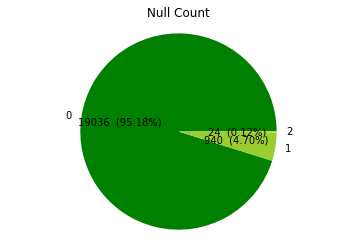

In [20]:
create_fill(df_all, numeric_features)
fill_numeric_features_with_mean(df_all, numeric_features)
remove_fill(df_all, numeric_features)
plot_rows_with_nan(df_all, "Null Count")

__Now all there is left is the categorical data__

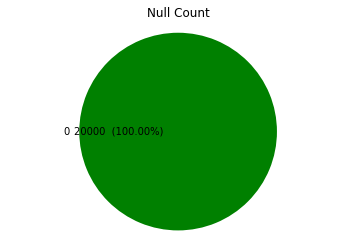

In [21]:
def fill_cat_simple(df, categorical_features):
    for f in categorical_features:
        df[f].fillna(Counter(df[f].dropna()).most_common(1)[0][0], inplace=True)
        
fill_cat_simple(df_all, categorical_features)
plot_rows_with_nan(df_all, "Null Count")


# Looks like we are done with data imputation
### Now we can transform and scale the data
#### Lets look what we have

In [22]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 37 columns):
%Of_Household_Income                             20000 non-null float64
%Time_invested_in_work                           20000 non-null float64
%_satisfaction_financial_policy                  20000 non-null float64
AVG_lottary_expanses                             20000 non-null float64
Age_group                                        20000 non-null object
Avg_Residancy_Altitude                           20000 non-null float64
Avg_Satisfaction_with_previous_vote              20000 non-null float64
Avg_education_importance                         20000 non-null float64
Avg_environmental_importance                     20000 non-null float64
Avg_government_satisfaction                      20000 non-null float64
Avg_monthly_expense_on_pets_or_plants            20000 non-null float64
Avg_monthly_expense_when_under_age_21            20000 non-null float64
Avg_monthly_household_cost  

In [23]:
def transform_bool(_df, name):
    _df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(float)


def transform_category(_df, name):
    for cat in _df[name].unique():
        _df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(float)
    del _df[name]


def transform_manual(_df):
    _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(float)
    _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(float)
    _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(float)

    transform_bool(_df, "Looking_at_poles_results")
    transform_bool(_df, "Married")
    transform_bool(_df, "Financial_agenda_matters")
    transform_bool(_df, "Will_vote_only_large_party")
    transform_category(_df, "Most_Important_Issue")
    transform_category(_df, "Occupation")
    transform_category(_df, "Main_transportation")
    
transform_manual(df_all)


In [24]:
def scale_numeric(_df, features):
    for f in features:
        _df[f] = (_df[f] - _df[f].min()) / (_df[f].max() - _df[f].min())
        
scale_numeric(df_all, numeric_features)

In [25]:
df_all.describe()

,%Of_Household_Income,%Time_invested_in_work,%_satisfaction_financial_policy,AVG_lottary_expanses,Age_group,Avg_Residancy_Altitude,Avg_Satisfaction_with_previous_vote,Avg_education_importance,Avg_environmental_importance,Avg_government_satisfaction,...,Is_Most_Important_Issue_Other,Is_Occupation_Hightech,Is_Occupation_Services_or_Retail,Is_Occupation_Industry_or_other,Is_Occupation_Public_Sector,Is_Occupation_Student_or_Unemployed,Is_Main_transportation_Public_or_other,Is_Main_transportation_Motorcycle_or_truck,Is_Main_transportation_Car,Is_Main_transportation_Foot_or_bicycle
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.00000
mean,0.500066,0.502281,0.498910,0.318778,0.999550,0.497603,0.431037,0.501231,0.502830,0.498451,...,0.054050,0.199650,0.196100,0.207350,0.199850,0.19705,0.246900,0.258300,0.248900,0.24590
std,0.284929,0.287233,0.288674,0.094720,0.807826,0.286502,0.136997,0.286683,0.286232,0.287199,...,0.226122,0.399747,0.397055,0.405419,0.399897,0.39778,0.431219,0.437711,0.432387,0.43063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,0.256365,0.254788,0.249737,0.260159,0.000000,0.251452,0.333615,0.256727,0.256492,0.248306,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
50%,0.501942,0.501319,0.496147,0.292746,1.000000,0.496984,0.392980,0.504856,0.502444,0.500382,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
75%,0.741296,0.749702,0.749856,0.344399,2.000000,0.745580,0.492940,0.745466,0.748352,0.745353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000


In [26]:
# df_Votes = df_all['Vote']
# df_Ids = df_all['IdentityCard_Num']
# df_split = df_all['split']

df_all['split'] = df_split
df_all['Vote'] = df_Votes
df_all['IdentityCard_Num'] = df_Ids

# train_split = 0
# test_split = 1
# validation_split = 2
# new_split = 3

df_train = df_all[df_all['split'] == train_split]
df_test = df_all[df_all['split'] == test_split]
df_validation = df_all[df_all['split'] == validation_split]

df_init_data = df_all[df_all['split'] != new_split]
df_new = df_all[df_all['split'] == new_split]

In [27]:
df_train_X = df_train.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_train_Y = df_train['Vote']

df_test_X = df_test.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_test_Y = df_test['Vote']

df_validation_X = df_validation.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_validation_Y = df_validation['Vote']

df_init_data_X = df_init_data.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)
df_init_data_Y = df_init_data['Vote']


df_new_Ids = df_new['IdentityCard_Num']
df_new_X = df_new.drop(['split', 'Vote', 'IdentityCard_Num'],axis=1)


In [28]:
fixes_useful_features = [
    'Avg_Satisfaction_with_previous_vote',
    'Number_of_valued_Kneset_members',
    'Yearly_IncomeK',
    'Overall_happiness_score',
    'Avg_monthly_expense_when_under_age_21',
    'Will_vote_only_large_party',
    'Garden_sqr_meter_per_person_in_residancy_area',
    'Is_Most_Important_Issue_Other',
    'Is_Most_Important_Issue_Financial',
    'Is_Most_Important_Issue_Environment',
    'Is_Most_Important_Issue_Military',
    'Is_Most_Important_Issue_Education',
    'Is_Most_Important_Issue_Foreign_Affairs',
    'Is_Most_Important_Issue_Social'
]

df_test_X = df_test_X[fixes_useful_features]
df_train_X = df_train_X[fixes_useful_features]
df_init_data_X = df_init_data_X[fixes_useful_features] 
df_new_X = df_new_X[fixes_useful_features]


#### We pick the same algorithm we did in Ex03, lets see if it still works

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report


clf = RandomForestClassifier(min_samples_split=4, n_estimators=100, random_state=0)
pred = cross_val_predict(clf, df_train_X.values, df_train_Y.values, cv=30)
print "***** %s *****" % clf.__class__.__name__
print classification_report(df_train_Y.values, pred, digits=5)


clf = RandomForestClassifier(min_samples_split=4, n_estimators=100, random_state=0)
pred = cross_val_predict(clf, df_init_data_X.values, df_init_data_Y.values, cv=30)
print "***** %s *****" % clf.__class__.__name__
print classification_report(df_init_data_Y.values, pred, digits=5)



***** RandomForestClassifier *****
             precision    recall  f1-score   support

      Blues    0.90232   0.98375   0.94128       554
     Browns    0.91037   0.98386   0.94569      1115
     Greens    0.99686   0.99581   0.99633       955
      Greys    0.98294   0.94737   0.96482       304
    Oranges    0.92035   0.96296   0.94118       324
      Pinks    0.97256   0.89432   0.93180       634
    Purples    0.98122   0.99130   0.98624      1265
       Reds    0.97476   0.95077   0.96262       325
     Whites    0.93252   0.73077   0.81941       208
    Yellows    0.96591   0.80696   0.87931       316

avg / total    0.95630   0.95500   0.95419      6000

***** RandomForestClassifier *****
             precision    recall  f1-score   support

      Blues    0.90807   0.98232   0.94374       905
     Browns    0.92690   0.98278   0.95402      1858
     Greens    0.99816   0.99754   0.99785      1629
      Greys    0.97037   0.95100   0.96059       551
    Oranges    0.93002   

Around 96%, looks good!

Lets try it on the test data

In [30]:
clf = RandomForestClassifier(min_samples_split=4, n_estimators=100, random_state=0)
clf.fit(df_train_X.values, df_train_Y.values)

pred = clf.predict(df_test_X.values)
distribution = Counter(pred)
print distribution

print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]


Counter({'Purples': 411, 'Browns': 394, 'Greens': 332, 'Blues': 207, 'Pinks': 187, 'Greys': 127, 'Reds': 110, 'Oranges': 98, 'Yellows': 80, 'Whites': 54})
predicted winner is party ## Purples ##


In [31]:
def evaluate_miss_rate(target, pred):
    miss_vals = []
    real_vals = []
    toples = []

    miss_count = 0
    for i, j in enumerate(pred):
        if pred[i] != target[i]:
            miss_vals.append(pred[i][0])
            real_vals.append(target[i][0])
            toples.append((pred[i][0],target[i][0]))
            miss_count = miss_count + 1

    print "Total Wrong predictions %d out of %d, hit rate: %f"% (miss_count, target.size, 100 - miss_count/float(target.size) * 100) + '%'
    
evaluate_miss_rate(df_test_Y.values, pred)

Total Wrong predictions 91 out of 2000, hit rate: 95.450000%


Almost 95%, looks good enough

### Prediction part
We picked RandomForestClassifier with min_samples_split=4 as we did in Ex03, lets try and see who wins the elections on the new data.

In [32]:
clf = RandomForestClassifier(min_samples_split=4, n_estimators=200, random_state=0)
clf.fit(df_init_data_X.values, df_init_data_Y.values)

PredictVote = clf.predict(df_new_X.values)
distribution = Counter(PredictVote)
print distribution

print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]


Counter({'Browns': 2375, 'Purples': 2057, 'Pinks': 1201, 'Greens': 1023, 'Blues': 1014, 'Oranges': 718, 'Greys': 595, 'Reds': 406, 'Yellows': 343, 'Whites': 268})
predicted winner is party ## Browns ##


## The Browns will win!!

Now lets glue up some stuff to export the prediction and try to cluster

In [33]:
new_data = df_new_X
new_data['Vote'] = PredictVote

new_data_X = df_new_X
new_data_Y = new_data['Vote']

new_data.head(10)

,Avg_Satisfaction_with_previous_vote,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_monthly_expense_when_under_age_21,Will_vote_only_large_party,Garden_sqr_meter_per_person_in_residancy_area,Is_Most_Important_Issue_Other,Is_Most_Important_Issue_Financial,Is_Most_Important_Issue_Environment,Is_Most_Important_Issue_Military,Is_Most_Important_Issue_Education,Is_Most_Important_Issue_Foreign_Affairs,Is_Most_Important_Issue_Social,Vote
0,0.455042,0.272727,0.506628,0.532357,0.455042,-1.0,0.402306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Browns
1,0.440611,0.090909,0.559095,0.505152,0.440611,0.0,0.414293,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Oranges
2,0.643283,0.818182,0.727119,0.678500,0.643283,1.0,0.401382,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Blues
3,0.319410,0.000000,0.481105,0.525691,0.319410,-1.0,0.402148,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Browns
4,0.227031,0.909091,0.671306,0.759872,0.227031,1.0,0.188011,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Yellows
5,0.579418,0.000000,0.487616,0.492756,0.579418,-1.0,0.397093,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Browns
6,0.344995,0.000000,0.444918,0.476965,0.344995,-1.0,0.361719,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Browns
7,0.312407,0.090909,0.358912,0.660841,0.312407,-1.0,0.388769,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Whites
8,0.365425,0.454545,0.642340,0.784204,0.365425,-1.0,0.336405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Greens
9,0.356286,0.000000,0.435539,0.490283,0.356286,-1.0,0.372489,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Browns


In [34]:

export_data = pd.DataFrame()
export_data['IdentityCard_Num'] = df_new['IdentityCard_Num'].astype(int)
export_data['PredictVote'] = PredictVote
export_data.to_csv('./predicted_new.csv', index=False, sep=',')

### Vote Distribution

In [35]:
print "Vote distribution"
vote_dist = Counter(PredictVote)
common = vote_dist.most_common()
for party in common: 
    print "%s - Votes: %d - Percents: %0.2f%%"%(party[0], party[1], float(party[1])/ len(PredictVote) * 100.0)


Vote distribution
Browns - Votes: 2375 - Percents: 23.75%
Purples - Votes: 2057 - Percents: 20.57%
Pinks - Votes: 1201 - Percents: 12.01%
Greens - Votes: 1023 - Percents: 10.23%
Blues - Votes: 1014 - Percents: 10.14%
Oranges - Votes: 718 - Percents: 7.18%
Greys - Votes: 595 - Percents: 5.95%
Reds - Votes: 406 - Percents: 4.06%
Yellows - Votes: 343 - Percents: 3.43%
Whites - Votes: 268 - Percents: 2.68%


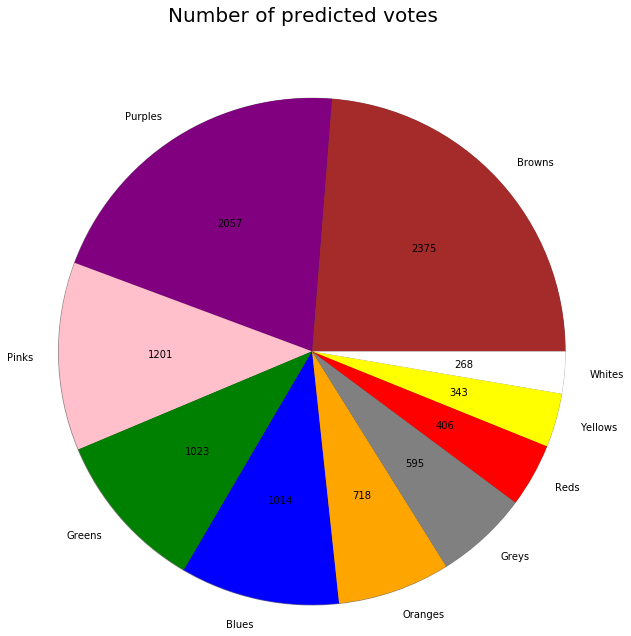

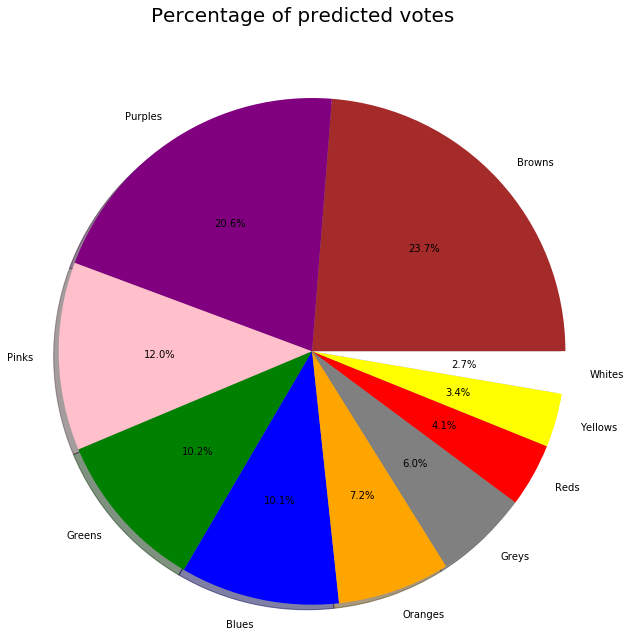

In [36]:
c = vote_dist.most_common()
parties, votes = zip(*[x for x in c])

colors = [x[:-1] for x in parties]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie([x[1] for x in c], labels=parties, colors=colors, autopct=lambda(p): '{:.0f}'.format(p * PredictVote.size / 100),
        shadow=True, radius=20)
ax1.axis('equal')
fig1.suptitle('Number of predicted votes',fontsize=20)

total_votes = new_data.shape[0]
ratios = [float(v)/total_votes for v in votes]
fig2, ax2 = plt.subplots(figsize=(10, 10))
ax2.pie(ratios, labels=parties, colors=colors, autopct='%00.1f%%', shadow=True)
ax2.axis('equal')
fig2.suptitle('Percentage of predicted votes',fontsize=20)

plt.show()

# Clustering
This is basically what we did in ex04
There we dicided to go for K=10 as k for KMeans

In [37]:
k = 10

In [38]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=k, verbose=0, random_state=0)
print "Training: K=%d" % k
km.fit(df_init_data_X)
print "Done"

Training: K=10
Done


In [39]:
def k_means_party_distribution(clf, X, Y, k):
    df_Y = Y.copy().to_frame()
    df_Y['cluster'] = clf.labels_
        
    res = {}
    for i in range(0, k):
        my_df = df_Y[df_Y['cluster'] == i]
        c = Counter(my_df['Vote'].values)
        res[i] = c
    return res

In [40]:
def basic_distribution(dist):
    for key,val in dist.iteritems():
        items = val.most_common()
        keys = []
        values = []
        for item in items:
            keys.append(item[0])
            values.append(item[0])

        print "Group: %s, Distribution: %s"%(str(key), sorted(keys))

In [41]:
dist_per_cluster = k_means_party_distribution(km, df_init_data_X, df_init_data_Y, k)

basic_distribution(dist_per_cluster)

Group: 0, Distribution: ['Browns', 'Greens', 'Greys', 'Pinks', 'Purples', 'Reds', 'Whites', 'Yellows']
Group: 1, Distribution: ['Blues', 'Yellows']
Group: 2, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites', 'Yellows']
Group: 3, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Group: 4, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites', 'Yellows']
Group: 5, Distribution: ['Blues', 'Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Group: 6, Distribution: ['Oranges', 'Reds']
Group: 7, Distribution: ['Greys', 'Oranges']
Group: 8, Distribution: ['Blues', 'Yellows']
Group: 9, Distribution: ['Greys', 'Reds']


Looks lide there is a small leak of parties, lets check how big is it.

In [42]:
def k_means_cluster_distribution(clf, X, Y):
    df_Y = Y.copy().to_frame()
    df_Y['cluster'] = clf.labels_
        
    res = {}
    
    for i in Y.unique():
        my_df = df_Y[df_Y['Vote'] == i]
        c = Counter(my_df['cluster'].values)
        res[i] = c
    return res


dist_per_party = k_means_cluster_distribution(km ,df_init_data_X, df_init_data_Y)
basic_distribution(dist_per_party)

Group: Reds, Distribution: [0, 6, 9]
Group: Greens, Distribution: [0, 2, 3, 4, 5]
Group: Whites, Distribution: [0, 2, 3, 4, 5]
Group: Yellows, Distribution: [0, 1, 2, 4, 8]
Group: Greys, Distribution: [0, 7, 9]
Group: Oranges, Distribution: [6, 7]
Group: Browns, Distribution: [0, 2, 3, 4, 5]
Group: Pinks, Distribution: [0, 2, 3, 4, 5]
Group: Blues, Distribution: [1, 5, 8]
Group: Purples, Distribution: [0, 2, 3, 4, 5]


In [43]:
print ("_" *22) + "dist per cluster" + ("_" *22)
print "_" * 60
for i in dist_per_cluster:
    print i,dist_per_cluster[i]
    
print 
print ("_" *22) + " dist per party " + ("_" *22)
print "_" * 60    
for i in dist_per_party:
    print i,dist_per_party[i]

______________________dist per cluster______________________
____________________________________________________________
0 Counter({'Purples': 410, 'Browns': 352, 'Greens': 334, 'Pinks': 193, 'Whites': 58, 'Reds': 2, 'Yellows': 2, 'Greys': 1})
1 Counter({'Blues': 700, 'Yellows': 422})
2 Counter({'Purples': 415, 'Browns': 365, 'Greens': 296, 'Pinks': 244, 'Whites': 77, 'Yellows': 1})
3 Counter({'Purples': 414, 'Browns': 390, 'Greens': 313, 'Pinks': 204, 'Whites': 63})
4 Counter({'Purples': 418, 'Browns': 381, 'Greens': 350, 'Pinks': 189, 'Whites': 73, 'Yellows': 3})
5 Counter({'Purples': 410, 'Browns': 370, 'Greens': 336, 'Pinks': 215, 'Whites': 65, 'Blues': 1})
6 Counter({'Reds': 280, 'Oranges': 252})
7 Counter({'Greys': 300, 'Oranges': 282})
8 Counter({'Blues': 204, 'Yellows': 105})
9 Counter({'Reds': 260, 'Greys': 250})

______________________ dist per party ______________________
____________________________________________________________
Reds Counter({6: 280, 9: 260, 0: 2})
Green

Looks like the Red leaked a little bit to cluster 0 (2 votes)

And the yellows leaked to clusters (4, 0 and 2)

But it is only in very small number, maybe it is because we did the outlier detection little bit differently

we will ignore the leak in this part

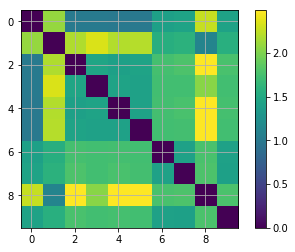

[[ 0.     2.09   1.013  1.019  1.003  1.005  1.414  1.443  2.269  1.429]]
[[ 2.09   0.     2.193  2.343  2.2    2.21   1.557  1.596  1.119  1.573]]
[[ 1.013  2.193  0.     1.459  1.417  1.438  1.748  1.787  2.486  1.769]]
[[ 1.019  2.343  1.459  0.     1.441  1.418  1.731  1.735  2.044  1.734]]
[[ 1.003  2.2    1.417  1.441  0.     1.426  1.739  1.77   2.48   1.755]]
[[ 1.005  2.21   1.438  1.418  1.426  0.     1.729  1.742  2.48   1.736]]
[[ 1.414  1.557  1.748  1.731  1.739  1.729  0.     1.426  1.777  1.418]]
[[ 1.443  1.596  1.787  1.735  1.77   1.742  1.426  0.     1.79   1.417]]
[[ 2.269  1.119  2.486  2.044  2.48   2.48   1.777  1.79   0.     1.78 ]]
[[ 1.429  1.573  1.769  1.734  1.755  1.736  1.418  1.417  1.78   0.   ]]
Mean distance: 1.522960


In [44]:
from sklearn.metrics.pairwise import euclidean_distances

def build_distance_matrix(clf):
    m = euclidean_distances(clf.cluster_centers_, clf.cluster_centers_)
    m = np.around(m, decimals=3)
    
    matrix = np.matrix(m)
    plt.imshow(matrix, interpolation='nearest')
    plt.colorbar()
    plt.grid(True)
    plt.show()
    return matrix
    
matrix = build_distance_matrix(km)
for i in matrix:
    print i


print "Mean distance: %f" %matrix.mean()


In [45]:
from operator import itemgetter

def build_candidates_for_merge(matrix):
    med = matrix.mean()
    pairs = []

    for i, line in enumerate(np.asarray(matrix)):
        for j, col in enumerate(line):
            if i < j and col < med:
                pairs.append((i,j, col))
            
    return  sorted(pairs, key=itemgetter(2))


pairs = build_candidates_for_merge(matrix)
for i in pairs:
    print i[0], sorted(dist_per_cluster[i[0]].keys())
    print i[1], sorted(dist_per_cluster[i[1]].keys())
    print "Clusters: %d --> %d, distance: %.03f"%i
    print "_" * 50

0 ['Browns', 'Greens', 'Greys', 'Pinks', 'Purples', 'Reds', 'Whites', 'Yellows']
4 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites', 'Yellows']
Clusters: 0 --> 4, distance: 1.003
__________________________________________________
0 ['Browns', 'Greens', 'Greys', 'Pinks', 'Purples', 'Reds', 'Whites', 'Yellows']
5 ['Blues', 'Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Clusters: 0 --> 5, distance: 1.005
__________________________________________________
0 ['Browns', 'Greens', 'Greys', 'Pinks', 'Purples', 'Reds', 'Whites', 'Yellows']
2 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites', 'Yellows']
Clusters: 0 --> 2, distance: 1.013
__________________________________________________
0 ['Browns', 'Greens', 'Greys', 'Pinks', 'Purples', 'Reds', 'Whites', 'Yellows']
3 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Clusters: 0 --> 3, distance: 1.019
__________________________________________________
1 ['Blues', 'Yellows']
8 ['Blues', 'Yellows']
Clusters: 1 --> 8, distance: 1.119
________

In [46]:
coalition = ['Purples', 'Browns', 'Greens', 'Pinks', 'Whites']
non_coalition = ['Greys', 'Oranges', 'Reds', 'Yellows', 'Blues']
coalition_clusters = [0,4,5,2,3]

In [47]:
def in_coal(row):
    if row["Vote"] in coalition:
        return 1
    else:
        return 0

def count_coalition(X, Y):
    df = Y.copy().to_frame()
    
    df['coal'] = df.apply (lambda row: in_coal(row),axis=1)
    val_counts = df['coal'].value_counts()
    print "In Coualtion the are %d votes which are %.02f%% percent"%(val_counts[1], float(val_counts[1]) / len(Y) * 100)

    
count_coalition(df_init_data_X, df_init_data_Y) 

In Coualtion the are 6935 votes which are 69.35% percent


In [48]:
count_coalition(df_new_X.drop(['Vote'], axis=1), df_new_X['Vote'])

In Coualtion the are 6924 votes which are 69.24% percent


In [49]:

def predict_clustering(clf, X):
    cluster_pred = clf.predict(X)
    return cluster_pred

def count_coalition_clusters(pred):
    c = Counter(pred)
    in_coal = sum(c[cid] for cid in coalition_clusters)
    total = sum(c.values())  
    print "Clustering - In Coualtion clusters the are %d votes which are %.02f%% percent"%(in_coal, float(in_coal) / total * 100)

clustering_prediction = predict_clustering(km, df_new_X.drop(['Vote'], axis=1))  
count_coalition_clusters(clustering_prediction)

Clustering - In Coualtion clusters the are 6926 votes which are 69.26% percent


In [50]:
def in_coal_and_coal_cluster(row):
    if row["Vote"] in coalition and row["cluster"] in coalition_clusters:
        return 1
    else:
        return 0
    
    
def count_coalition_with_cluster(_df, pred):
    df = _df.copy()
    df['cluster'] = pred

    df['coal+cluster'] = df.apply (lambda row: in_coal_and_coal_cluster(row),axis=1)
    val_counts = df['coal+cluster'].value_counts()
    print "In Coualtion + coalition clusters the are %d votes which are %.02f%% percent"%(val_counts[1], float(val_counts[1]) / len(_df) * 100)

clustering_prediction = predict_clustering(km, df_new_X.drop(['Vote'], axis=1))  
count_coalition_with_cluster(df_new_X, clustering_prediction)
    

In Coualtion + coalition clusters the are 6922 votes which are 69.22% percent
